# Hello!  
In this notebook we can see the definition of the functions and the relevant matrices, with a single simulation and its visualisation.  
In the end you can see the steps of one trial, shown as the location of the agent, and it's belief histogram.

# Imports

In [21]:
""" In case you use colab notebook, you should install inferactively-pymdp"""

! pip install inferactively-pymdp

In [22]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pymdp
from pymdp import utils
from pymdp.maths import softmax

## Defining plot functions


In [39]:

def plot_likelihood(matrix, xlabels=list(range(9)), ylabels=list(range(9)), title_str="Likelihood distribution (A)"):
    """
    Plots a 2-D likelihood matrix as a heatmap
    """

    if not np.isclose(matrix.sum(axis=0), 1.0).all():
        raise ValueError(
            "Distribution not column-normalized! Please normalize (ensure matrix.sum(axis=0) == 1.0 for all columns)")

    fig = plt.figure(figsize=(6, 6))
    ax = sns.heatmap(matrix, xticklabels=xlabels, yticklabels=ylabels, cmap='gray', cbar=False, vmin=0.0, vmax=1.0)
    plt.title(title_str)
    plt.show()


def plot_grid(grid_locations, num_x=3, num_y=5):
    """
    Plots the spatial coordinates of GridWorld as a heatmap, with each (X, Y) coordinate
    labeled with its linear index (its `state id`)
    """

    grid_heatmap = np.zeros((num_x, num_y))
    for linear_idx, location in enumerate(grid_locations):
        y, x = location
        grid_heatmap[y, x] = linear_idx
    sns.set(font_scale=1.5)
    sns.heatmap(grid_heatmap, annot=True, cbar=False, fmt='.0f', cmap='crest')


def plot_point_on_grid(state_index, grid_locations, context = 'No'):
    """
    Plots the current location of the agent on the grid world, and the context (if provided)
    """
    y, x = grid_locations[state_index]
    grid_heatmap = np.zeros((3, 5))
    if context != 'No':
        if context == 'Left-Better':
          grid_heatmap[0, 0] = 0.5
          plt.text(x = 0, y = 0.5, s = "Reward")
        else:
          grid_heatmap[0, 4] = 0.5
          plt.text(x = 4.1, y = 0.5, s = "Reward")
    grid_heatmap[1:3,0:2] = -1.0  # representing the walls the agent cant pass
    grid_heatmap[1:3,3:5] = -1.0  # representing the walls the agent cant pass
    grid_heatmap[y, x] = 1.0
    sns.heatmap(grid_heatmap, cmap = 'viridis', vmin = -1, vmax = 1, center = 0)
    plt.text(x = 2.2 , y = 2.5, s = "Hint loc")



def plot_beliefs(belief_dist, title_str=""):
    """
    Plot a categorical distribution or belief distribution, stored in the 1-D numpy vector `belief_dist`
    """

    if not np.isclose(belief_dist.sum(), 1.0):
        raise ValueError("Distribution not normalized! Please normalize")

    plt.grid(zorder=0)
    plt.bar(range(belief_dist.shape[0]), belief_dist, color='r', zorder=3)
    plt.xticks(range(belief_dist.shape[0]))
    plt.title(title_str)
    plt.show()



## Defining grid and context

In [24]:

import itertools

""" Create  the grid locations in the form of a list of (Y, X) tuples -- HINT: use itertools """
grid_locations = list(itertools.product(range(5), repeat = 2))
grid_locations = grid_locations[:15]


context_names = ['Left-Better', 'Right-Better']
choice_names = list(range(len(grid_locations)))

""" Define `num_states` and `num_factors` below """
num_states = [len(context_names), len(choice_names)]
num_factors = len(num_states)

context_action_names = ['Do-nothing']
choice_action_names = ["UP", "DOWN", "LEFT", "RIGHT", "STAY"]

""" Define `num_controls` below """
num_controls = [len(context_action_names), len(choice_action_names)]

hint_obs_names = ['Null', 'Hint-left', 'Hint-right']
reward_obs_names = ['Null', 'Loss', 'Reward']
choice_obs_names = choice_names

""" Define `num_obs` and `num_modalities` below """
num_obs = [len(hint_obs_names), len(reward_obs_names), len(choice_obs_names)]
num_modalities = len(num_obs)

# Define A, B, C and D tensors  
create_A(): Generates the observation likelihood matrix (how the agent perceives the environment).  
create_B(): Defines the agent’s state transitions (how the agent's actions change its state).  
create_C(): Constructs the agent’s reward matrix (how rewards and punishments affect the agent’s decisions).  
create_D(): Defines the agent's initial beliefs about its context and location.  
run_active_inference_loop(): Executes the active inference loop, where the agent continuously updates its beliefs and chooses actions based on expected free energy.
## Matrix A



In [5]:

def create_A(p_hint=0.7, p_reward=0.8):
  """
  Function for creating the observation (observation or sensory likelihood) model for the contextual MAB task, parameterized by
  two probabilities: `p_hint` and `p_reward`.
  Parameters:
  ----------
  `p_hint`: float (default 0.7)
    accuracy of the hint, according to the agent's generative model (how much does the agent trust the hint?)
  `p_reward`: float (default 0.8)
    probability of getting a rewarding outcome when sampling the more rewarding bandit, according to the agent's generative model
  Returns:
  ---------
  `A`: numpy object array
    The full observation likelihood model
  """
  A = utils.initialize_empty_A(num_obs, num_states)

  """ Fill out the hint modality """
  A_hint = np.zeros((len(hint_obs_names), len(context_names), len(choice_names)))
  for choice_id, choice_name in enumerate(choice_names):
      if choice_name == 12:
          A_hint[1:, :, choice_id] = np.array([[p_hint, 1.0 - p_hint],
                                               [1.0 - p_hint, p_hint]])
      else:
          A_hint[0, :, choice_id] = 1.0

  """ Fill out the reward modality """
  A_reward = np.zeros((len(reward_obs_names), len(context_names), len(choice_names)))
  for choice_id, choice_name in enumerate(choice_names):
      if choice_name == 0:  # left arm index
          A_reward[1:, :, choice_id] = np.array([[1.0 - p_reward, p_reward],
                                                 [p_reward, 1.0 - p_reward]])
      elif choice_name == 4:  # right arm index
          A_reward[1:, :, choice_id] = np.array([[p_reward, 1.0 - p_reward],
                                                 [1 - p_reward, p_reward]])
      else:
          A_reward[0, :, choice_id] = 1.0

  """ Fill out the choice sensation modality """
  A_choice = np.zeros((len(choice_obs_names), len(context_names), len(choice_names)))
  for choice_id in range(len(choice_names)):
      A_choice[choice_id, :, choice_id] = 1.0

  A[0], A[1], A[2] = A_hint, A_reward, A_choice

  return A

## Matrix B

In [6]:

def create_B(p_change=0.0):
    """
    Function for creating the transition (dynamics or transition likelihood) model for the contextual MAB task, parameterized by
    a context-change probability `p_change`.
    Parameters:
    ----------
    `p_change`: float (default 1.0)
      probability of the context (which bandit is more rewarding) changing
    Returns:
    ---------
    `B`: numpy object array
      The full transition likelihood model
    """
    B = utils.initialize_empty_B(num_states, num_states)

    """ Context transitions (uncontrollable) """
    B_context = np.zeros((len(context_names), len(context_names), len(context_action_names)))
    B_context[:, :, 0] = np.array([[1. - p_change, p_change],
                                   [p_change, 1. - p_change]]
                                  )

    """ Choice transitions (controllable) """
    actions = ["UP", "DOWN", "LEFT", "RIGHT", "STAY"]

    def create_B_choice_matrix():
        B = np.zeros((len(grid_locations), len(grid_locations), len(actions)))

        for action_id, action_label in enumerate(actions):
            for curr_state, grid_location in enumerate(grid_locations):

                y, x = grid_location

                if action_label == "UP":
                    next_y = y - 1 if y > 0 and x == 2 else y
                    next_x = x
                elif action_label == "DOWN":
                    next_y = y + 1 if y < 2 and x == 2 else y
                    next_x = x
                elif action_label == "LEFT":
                    next_x = x - 1 if x > 0 and x != 0 and y == 0 else x
                    next_y = y
                elif action_label == "RIGHT":
                    next_x = x + 1 if x < 4 and x != 4 and y == 0 else x
                    next_y = y
                elif action_label == "STAY":
                    next_x = x
                    next_y = y
                new_location = (next_y, next_x)
                next_state = grid_locations.index(new_location)
                B[next_state, curr_state, action_id] = 1.0
        return B

    B_choice = create_B_choice_matrix()

    B[0], B[1] = B_context, B_choice

    return B

## Matrix C

In [7]:
def create_C(reward=2., pun=-4., neutral = -1.):
  """ Creates the C array, AKA the observation prior for the MAB task,
   parameterized by a `reward`, `pun` (punishment) and 'neutral' parameters """

  C = utils.obj_array_zeros(num_obs)
  C[1] = np.array([neutral, pun, reward])
  return C

## Matrix D

In [8]:
def create_D(p_context=0.5):
  """
  Creates the D array AKA the hidden state prior at the first timestep for the MAB task, parameterized by a `p_context` parameter that
  parameterizes the agent's prior beliefs about whether the context is "Left Arm Better" at the first timestep of a given trial
  """

  D = utils.obj_array(num_factors)

  """ Context prior """
  D_context = np.array([p_context,1.-p_context])
  D[0] = D_context


  """ Choice-state prior """
  D_choice = np.zeros(len(choice_names))
  D_choice[choice_names[7]] = 1.0
  D[1] = D_choice

  return D

# Define the environment

Tmaze_grid: Defines the T-maze environment, including how the agent moves through the grid, receives hints, and observes rewards.  
Note that it is a grid, but the agent blocked from moving to some cells.  
If the agent want to move to the cells that are



In [9]:

class Tmaze_grid(object):
    """
  Class that creates the environment of a T-maze layout on a grid, as well as the dynamics between the environment and an agent.
  """

    def __init__(self, context=None, p_hint=1.0, p_reward=0.8):

        self.context_names = ["Left-Better", "Right-Better"]

        if context == None:
            self.context = self.context_names[
                utils.sample(np.array([0.5, 0.5]))]  # randomly sample which bandit arm is better (Left or Right)
        else:
            self.context = context

        self.p_hint = p_hint
        self.p_reward = p_reward

        self.reward_obs_names = ['Null', 'Loss', 'Reward']
        self.hint_obs_names = ['Null', 'Hint-left', 'Hint-right']



    def step(self, action_label, cur_state):
        actions = ["UP", "DOWN", "LEFT", "RIGHT", "STAY"]
        y, x = grid_locations[cur_state][0], grid_locations[cur_state][1]
        observed_reward = "Null"
        observed_hint = "Null"

        if action_label == "UP":
            next_y = y - 1 if y > 0 and x == 2 else y
            next_x = x
        elif action_label == "DOWN":
            next_y = y + 1 if y < 2 and x == 2 else y
            next_x = x
            if (next_y, next_x) == (2, 2):  ## reaching the hint state
                if self.context == "Left-Better":
                    observed_hint = self.hint_obs_names[
                        utils.sample(np.array([0.0, self.p_hint, 1.0 - self.p_hint]))]
                elif self.context == "Right-Better":
                    observed_hint = self.hint_obs_names[
                        utils.sample(np.array([0.0, 1.0 - self.p_hint, self.p_hint]))]

        elif action_label == "LEFT":
            next_x = x - 1 if x > 0 and y == 0 else x
            next_y = y
            if (next_y, next_x) == (0, 0):  ## reaching the end of left arm
                if self.context == "Left-Better":
                    observed_reward = self.reward_obs_names[
                        utils.sample(np.array([0.0, 1.0 - self.p_reward, self.p_reward]))]
                elif self.context == "Right-Better":
                    observed_reward = self.reward_obs_names[
                        utils.sample(np.array([0.0, self.p_reward, 1.0 - self.p_reward]))]

        elif action_label == "RIGHT":
            next_x = x + 1 if x < 4 and y == 0 else x
            next_y = y
            if (next_y, next_x) == (0, 4):  ## reaching the end of right arm
                if self.context == "Left-Better":
                    observed_reward = self.reward_obs_names[
                        utils.sample(np.array([0.0, 1.0 - self.p_reward, self.p_reward]))]
                elif self.context == "Right-Better":
                    observed_reward = self.reward_obs_names[
                        utils.sample(np.array([0.0, self.p_reward, 1.0 - self.p_reward]))]

        elif action_label == "STAY":
            next_x = x
            next_y = y
        new_location = (next_y, next_x)
        next_state = grid_locations.index(new_location)

        obs = [observed_hint, observed_reward, next_state]

        return obs

# Defining Active inference loop

In [10]:
def run_active_inference_loop(my_agent, my_env, T = 5, verbose = True):
  """
  Function that wraps together and runs a full active inference loop using the pymdp.agent.Agent class functionality
  """
  hint_obs_names = ['Null', 'Hint-left', 'Hint-right']
  reward_obs_names = ['Null', 'Loss', 'Reward']
  choice_names = list(range(len(grid_locations)))
  choice_obs_names = choice_names
  """ Initialize the first observation """
  obs_label = ["Null", "Null", 7]  # agent observes itself seeing a `Null` hint, getting a `Null` reward, and seeing itself in the `Start` location
  obs = [hint_obs_names.index(obs_label[0]), reward_obs_names.index(obs_label[1]), choice_obs_names.index(obs_label[2])]

  first_choice = choice_obs_names.index(obs_label[2])
  choice_hist = np.zeros((15,T+1))
  choice_hist[first_choice,0] = 1.0
  action_hist = np.zeros((5,T+1))

  belief_hist = np.zeros((2, T))
  context_hist = np.zeros(T)
  Outcome = "Null" # for collecting data of each trial
  n_hints = 0 # for collecting how much hints agent took each trial

  for t in range(T):
    context_hist[t] = env.context_names.index(env.context)
    qs = my_agent.infer_states(obs)

    belief_hist[:,t] = qs[0]

    if verbose:
      fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
      plt.subplot(1,2,2)
      plot_point_on_grid(obs[2], grid_locations, context = env.context)
      plt.subplot(1,2,1)
      utils.plot_beliefs(qs[0], title = f"Beliefs about the context at time {t}")
      plt.show()
    q_pi, efe = my_agent.infer_policies()
    chosen_action_id = my_agent.sample_action()

    movement_id = int(chosen_action_id[1])


    choice_action = choice_action_names[movement_id]
    action_hist[movement_id, t + 1] = 1.0
    cur_state = obs_label[2]
    if cur_state == 12:
      n_hints += 1


    obs_label = my_env.step(choice_action, choice_obs_names.index(obs_label[2]))
    choice_hist[choice_obs_names.index(obs_label[2]), t + 1] = 1.0
    obs = [hint_obs_names.index(obs_label[0]), reward_obs_names.index(obs_label[1]), choice_obs_names.index(obs_label[2])]
    if obs_label[1] == "Reward":
      Outcome = "Reward"
    elif obs_label[1] == "Loss":
      Outcome = "Loss"

    if verbose:
      print(f'Location at time {t}: {obs_label[2]}')
      print(f'Cue at time {t}: {obs_label[0]}')
      print(f'Action at time {t}: {choice_action}')
      print(f'Reward at time {t}: {obs_label[1]}')

  return action_hist, choice_hist, belief_hist, context_hist, Outcome, n_hints, cur_state


# Simulating ActInf  

Here, it will show how it looks like.  
In the visualization, the yellow square represents the agent, the dark cells represent unaccessible cells, and the green cell represents the rewarding arm.  
The agent starts at the central cell.   
The hint accuracy is set to 1 (Means the hint given is always right).  
The reward probability is set to 0.7 (Means the chance of recieving reward when reaching the rewarding arm. )

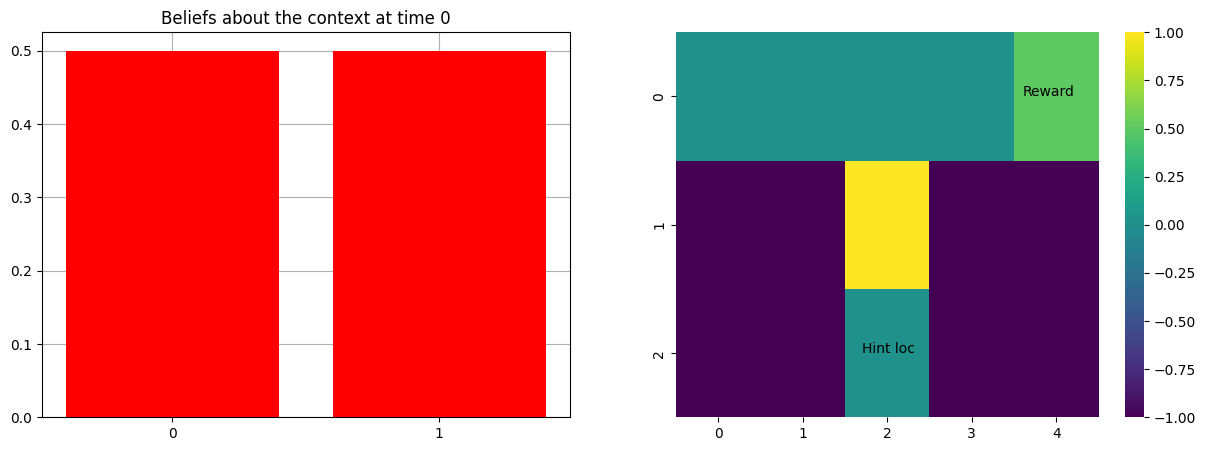

Location at time 0: 12
Cue at time 0: Hint-right
Action at time 0: DOWN
Reward at time 0: Null


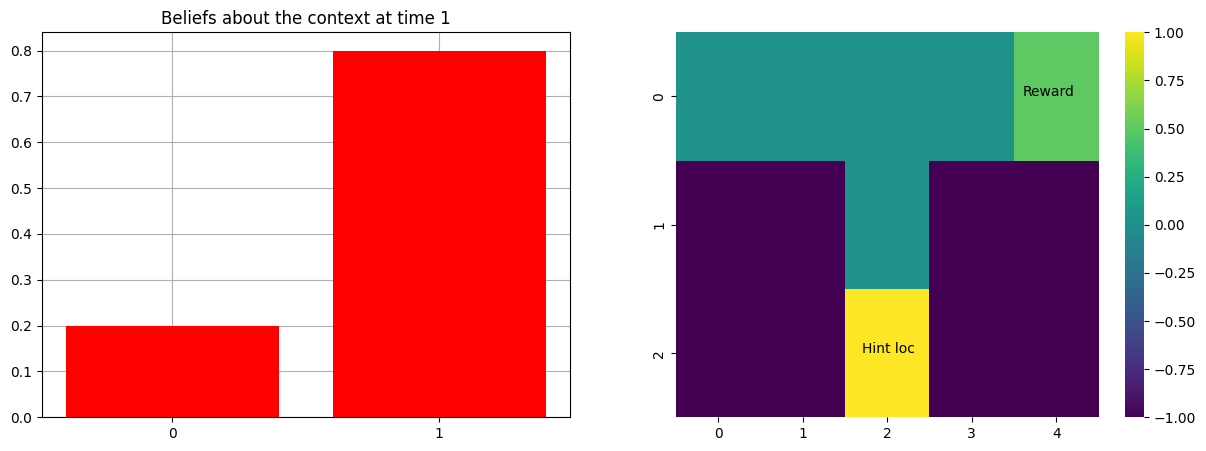

Location at time 1: 7
Cue at time 1: Null
Action at time 1: UP
Reward at time 1: Null


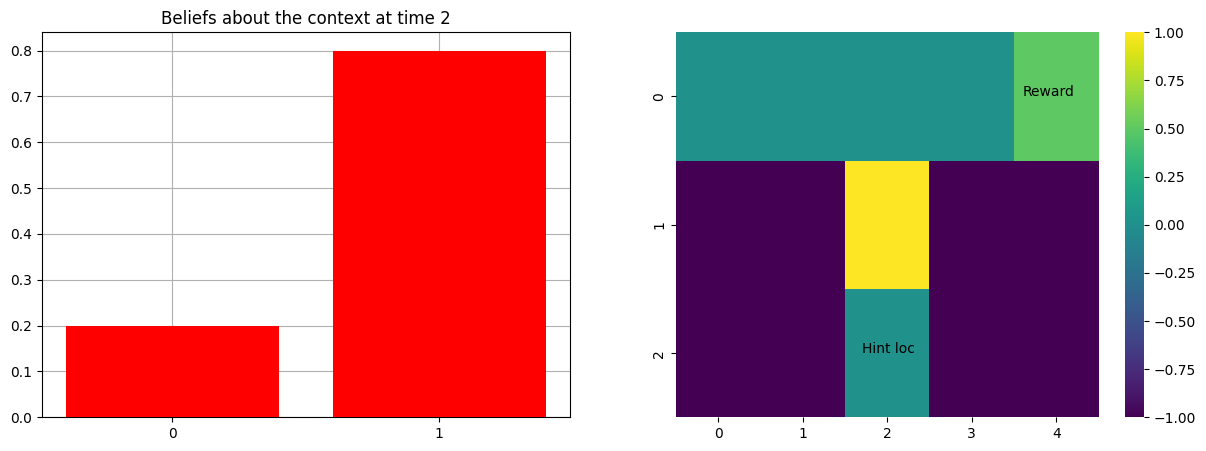

Location at time 2: 2
Cue at time 2: Null
Action at time 2: UP
Reward at time 2: Null


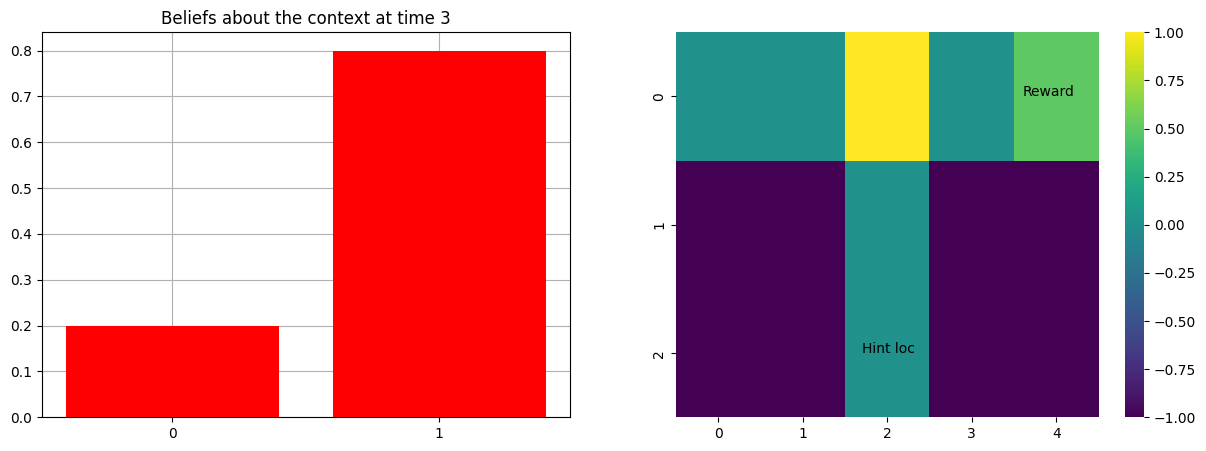

Location at time 3: 3
Cue at time 3: Null
Action at time 3: RIGHT
Reward at time 3: Null


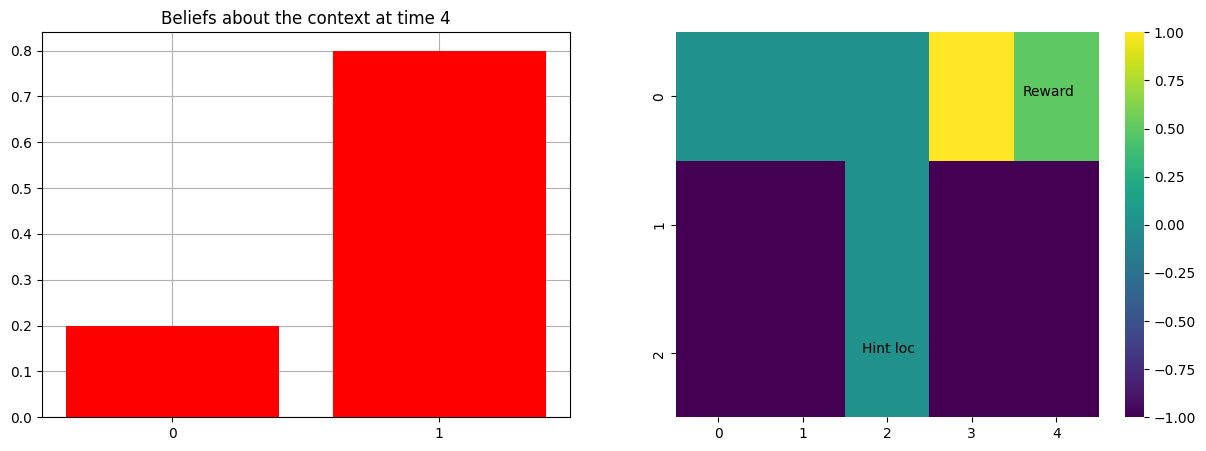

Location at time 4: 4
Cue at time 4: Null
Action at time 4: RIGHT
Reward at time 4: Reward


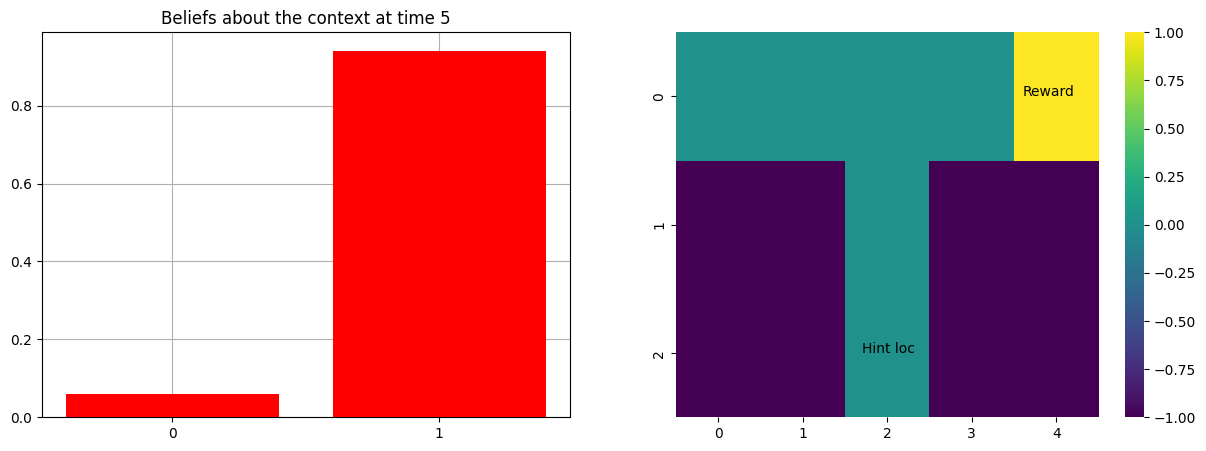

Location at time 5: 4
Cue at time 5: Null
Action at time 5: UP
Reward at time 5: Null


In [40]:

from pymdp.agent import Agent

p_hint_env = 1.0 # this is the "true" accuracy of the hint - i.e. how often does the hint actually signal which arm is better. REMEMBER: THIS IS INDEPENDENT OF HOW YOU PARAMETERIZE THE A MATRIX FOR THE HINT MODALITY
p_reward_env = 0.7 # this is the "true" reward probability - i.e. how often does the better arm actually return a reward, as opposed to a loss. REMEMBER: THIS IS INDEPENDENT OF HOW YOU PARAMETERIZE THE A MATRIX FOR THE REWARD MODALITY
env = Tmaze_grid(p_hint=p_hint_env, p_reward=p_reward_env)

T = 5
N_steps = 6
A = create_A(p_hint= 0.8, p_reward=0.8)
B = create_B(p_change=0.0)
C = create_C(reward=2.0, pun=-4.0)
D = create_D(p_context=0.5)
my_agent = Agent(A = A, B = B, C = C, D = D, policy_len = 5) # in case you want to re-define the agent, you can run this again
action_hist, choice_hist, belief_hist, context_hist, reward, n_hints, cur_state = run_active_inference_loop(my_agent, env, T = N_steps, verbose = True)